In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.eda_methods import show_barplot, load_data

In [2]:
old_commits, new_commits, cc_df, bic = load_data('accumulo')

In [3]:
# selects cochange of at least two components with confidence higher that 0.5
relevant_cc =\
    cc_df[
        (cc_df.support_count > 1) & (cc_df.confidence >= 0.5)
    ].reset_index(drop=True).copy()

# relevant_cc = cc_df.reset_index(drop=True).copy()

# frees memory
# del cc_df

**Note** that the hashes for cochange are the same as in new_commits but the hashes for bug introducing commits (bic) is the same as in old_commits. Thus, we must convert bic hashes into new_commits hashes.

In [4]:
# relevant_cc.iloc[0].commit_hash[0] in new_commits.values

# drops duplicated hashes 
bic = bic[~bic.duplicated()].reset_index(drop=True)
print('Number of bug introducing commits: {0}'.format(len(bic)))

Number of bug introducing commits: 775


In [5]:
# creates a dataframe to support conversion of old hashes into new ones
conv_df = pd.DataFrame()
conv_df['old_hash'] = old_commits.sort_index()
conv_df['new_hash'] =\
    new_commits.sort_index()\
    .reset_index(drop=True)[
        old_commits\
        .sort_index()\
        .reset_index(drop=True)\
        .index
    ].values

In [6]:
# converts bic's old hashes into new ones
bic =\
    conv_df.set_index('old_hash')\
    .squeeze()[bic.values]\
    .reset_index(drop=True)

### > How frequent are commits that introduce bugs?

In [7]:
# len(np.unique(bic.values)) / len(np.unique(old_commits.values))
len(np.intersect1d(bic.values, new_commits.values)) / len(np.unique(new_commits.values))

0.07531584062196307

### > How common is cochange in the project?

In [8]:
print(
    '{0:.3f} of all commits show cochange between components (support > 1, confidence >= 0.5).'
    .format(
        len(np.unique(np.hstack(relevant_cc.commit_hash.values))) / len(np.unique(old_commits.values))
    )
)

0.067 of all commits show cochange between components (support > 1, confidence >= 0.5).


### > Of all commits with cochange dependency, how many introduce bugs?

In [9]:
len(np.intersect1d(np.hstack(relevant_cc.commit_hash.values), bic.values)) / len(np.unique(np.hstack(relevant_cc.commit_hash.values)))

0.11661807580174927

### > Of all commits that introduce bugs, how many have cochange dependency? (questionable)

In [10]:
len(np.intersect1d(np.hstack(relevant_cc.commit_hash.values), bic.values)) / len(bic.values)

0.1032258064516129

## Distribuition of bug introducing commits over cochange dependency support (level)

### > Broad Overview

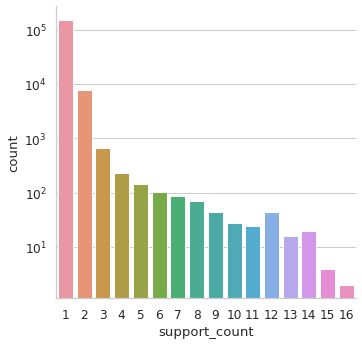

In [11]:
show_barplot(cc_df, 'support_count', y_logscale='log')

### > How many of the observations are unique?

In [12]:
# hashes the list of commits to check for duplicates
cc_df['id_hash'] = cc_df.commit_hash.apply(lambda x: hash(tuple(x)))

In [13]:
print(
    'Unique hashes of list of commit_hash: {0}\n'
    .format(
        len(cc_df) - cc_df.set_index('id_hash').index.duplicated().sum()
    )
    + 'Should the order of components influence the co-change dependency (a,b != b,a ?)? It does at this time.'
)

Unique hashes of list of commit_hash: 1950
Should the order of components influence the co-change dependency (a,b != b,a ?)? It does at this time.


In [14]:
unique_cc =\
    cc_df[
        ~cc_df.set_index('id_hash')
        .index.duplicated()
    ].reset_index(drop=True).copy()

unique_cc

,support_count,confidence,commit_hash,id_hash
0,1,1.0000,[f0dba1509f79b7a333b02d0be969cb419ae7f0ca],9076582216108358983
1,1,1.0000,[4afcea5c5d6283f14e5c404311f3f07559b4d496],-8864684178223992413
2,1,1.0000,[047b1c210d87fe53548ffbda2ac29ef946dd16bf],-1918493541504609363
3,2,1.0000,"[58342fbc4394630f2fe736e2fe2f4bbc0619c271, 6e1...",582259482416712035
4,1,1.0000,[dd4b075a9b2e83111476588e70e1cac2363e0ad5],8056308681179764156
...,...,...,...,...
1945,1,1.0000,[0067c81748358e71898487c5e8a87c518a2e967c],4095737608048081228
1946,12,0.7500,"[bec6fde0f7c4fe8df7fa2f33651bb5be16890496, 194...",-4905357737512971574
1947,1,0.3333,[5231242fafa924b56034123d6c6f4d6f244e5839],-9200955418846202911
1948,2,0.1818,"[dab4e58d168a1c2152fafe8b6b0024b38d9f246c, fd7...",3007650900924208054


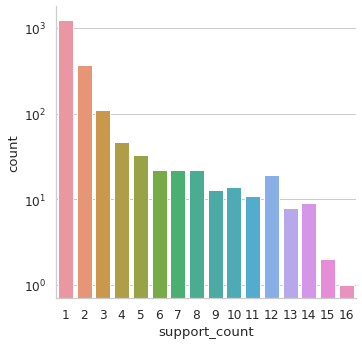

In [15]:
show_barplot(unique_cc, 'support_count', y_logscale=True)

### > How are bugs distributed over support_count categories?

In [16]:
unique_cc['bic_count'] =\
    unique_cc.commit_hash.apply(
        lambda x: len(
            [
                commit_h for commit_h in x
                if commit_h in bic.values
            ]
        )
    )

In [17]:
for name, group in unique_cc.groupby('support_count'):
    print('> Support count ', name)
    print('Cochange instances: \t\t', len(group))
    print('Cochange instances with bugs: \t', group[group['bic_count'] > 0]['bic_count'].count())
    print('Individual bic count: \t\t', group['bic_count'].sum(), '\n')

> Support count  1
Cochange instances: 		 1249
Cochange instances with bugs: 	 173
Individual bic count: 		 184 

> Support count  2
Cochange instances: 		 369
Cochange instances with bugs: 	 80
Individual bic count: 		 92 

> Support count  3
Cochange instances: 		 110
Cochange instances with bugs: 	 37
Individual bic count: 		 45 

> Support count  4
Cochange instances: 		 46
Cochange instances with bugs: 	 14
Individual bic count: 		 18 

> Support count  5
Cochange instances: 		 33
Cochange instances with bugs: 	 19
Individual bic count: 		 23 

> Support count  6
Cochange instances: 		 22
Cochange instances with bugs: 	 19
Individual bic count: 		 23 

> Support count  7
Cochange instances: 		 22
Cochange instances with bugs: 	 20
Individual bic count: 		 37 

> Support count  8
Cochange instances: 		 22
Cochange instances with bugs: 	 22
Individual bic count: 		 47 

> Support count  9
Cochange instances: 		 13
Cochange instances with bugs: 	 13
Individual bic count: 		 29 

> Su

In [83]:
# sns.catplot();
# unique_cc.groupby('support_count').agg(lambda x: x[x.bic_count > 0].bic_count.count() / len(x)).bic_count
compare_cc_bugs = pd.DataFrame()
compare_cc_bugs['cc_bugs'] = unique_cc.groupby('support_count').agg(lambda x: x[x.bic_count > 0].bic_count.count()).bic_count
compare_cc_bugs['cc_count'] = unique_cc.groupby('support_count').commit_hash.count()
compare_cc_bugs['cc_groups_with_bugs_percent'] = compare_cc_bugs.cc_bugs / compare_cc_bugs.cc_count
compare_cc_bugs['unique_commits_with_bugs_percent'] = unique_cc.groupby('support_count').bic_percent.mean()

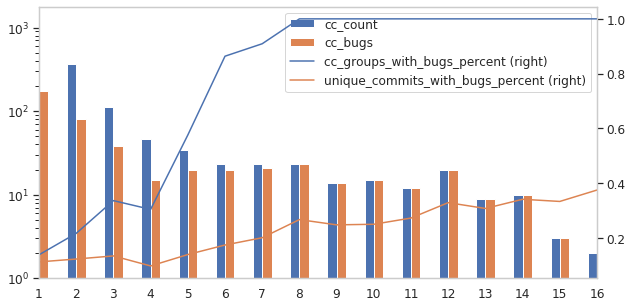

In [84]:
sns.set_style("whitegrid", {'axes.grid' : False})

ax = compare_cc_bugs[['cc_count', 'cc_bugs']]\
.plot(
    # secondary_y='cc_bugs_perc',
    kind='bar',
    log=True,
    # grid=False,
    figsize=(10,5)
)

compare_cc_bugs[['cc_groups_with_bugs_percent', 'unique_commits_with_bugs_percent']].plot(
    kind='line',
    secondary_y=True,
    # grid=False,
    ax=ax
)

In [79]:
unique_cc['bic_percent'] =\
    unique_cc[unique_cc.bic_count > 0][['commit_hash', 'bic_count']]\
    .apply(lambda x: x[1] / len(x[0]), axis=1)

unique_cc.bic_percent = unique_cc.bic_percent.fillna(0.0)

In [89]:
unique_cc[(unique_cc.commit_hash.apply(lambda x: len(x) > 2))]

,support_count,confidence,commit_hash,id_hash,bic_count,bic_percent
38,3,0.7500,"[9b783377f4714d2d6d09bc2e17f0a8a908ab1b22, 97d...",5322007754546881405,0,0.000000
178,3,1.0000,"[99cccc687536068066f6c9d112900f40b927e9bd, 296...",4904773583236645626,0,0.000000
221,8,0.5333,"[dab4e58d168a1c2152fafe8b6b0024b38d9f246c, c94...",-8250290123451470801,1,0.125000
224,4,0.5714,"[cbb2632ca0f2cbbbdf863bcd5f88f218d8a1f0b0, a1e...",-7368850147770649513,0,0.000000
230,6,0.4615,"[dab4e58d168a1c2152fafe8b6b0024b38d9f246c, 664...",4018935172121555834,1,0.166667
...,...,...,...,...,...,...
1928,3,0.7500,"[d2cc5630b9f3887ab3bbe34af689dd41cc939a98, c82...",1825115836400660610,1,0.333333
1933,3,0.7500,"[7315c1b3f7b4ad4b946c4ad53b5081fe7474bfc4, 0a8...",6004684095096188197,0,0.000000
1934,13,0.7222,"[bec6fde0f7c4fe8df7fa2f33651bb5be16890496, 194...",4387660002590064363,4,0.307692
1936,3,1.0000,"[202201ae52bdee8d7863a2d251ebc9433a73372b, ad8...",-1792884106823560272,0,0.000000


Compare the same data with commits without cochange
Relate the percentage of bugs in commits without cochange and commits with cochange